In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import add
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import re
import string
import nltk
import tensorflow as tf
from time import time
# import Tokenizer method from nltk
from nltk.tokenize import TweetTokenizer,word_tokenize
from nltk.corpus import stopwords
import multiprocessing
from unidecode import unidecode
from time import time
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer
from kneed import KneeLocator

#!pip install kneed
#!pip install unidecode

In [2]:
#load the data
data = pd.read_csv('C://Users//Naveena//Documents//EmotionAnalysis_DataSet/text-query-tweets_75k.csv')
data.head()
data.dtypes

Datetime          object
Tweet Id           int64
Place             object
Text              object
Username          object
FollowersCount     int64
FriendsCount       int64
Language          object
Hashtag           object
Retweet Count      int64
Likes Count        int64
dtype: object

In [3]:
data['Text'].astype('str').value_counts()

In its July 2020 report on #Yemen's situation : the @WorldBank stated that the fuel crisis caused by US-Saudi blockade continued with no improvement, disrupting basic services, facing #Coronavirus efforts and humanitarian operations activities  #USADetainsOilShips                                 432
Yoga guru Ramdev-run Patanjali has claimed that its Ayurvedic medicine 'Coronil' can help cure COVID-19 caused by the novel coronavirus.\n#Patanjalis_EvidenceBased_Medicine4Corona\n\n#PatanjaliCoronil                                                                                                 159
SARS-CoV-2, the coronavirus which causes COVID-19, does not care whether or not we are weary of this global pandemic.\n\nIts only objective is to survive by finding a host and replicating.\n\nCoronavirus Dashboard: https://t.co/M1DKt1vBeF                                                            63
Covid is likely to persist once its pandemic phase has passed and circulate each winter alongside

In [4]:
text= data.Text

In [5]:
def clean_text(df):
    all_tweets = list()
    lines = data["Text"].values.tolist()
    for text in lines:
        text = text.lower()
        
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        
        emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text = emoji.sub(r'', text)
        
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)        
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text) 
        text = re.sub(r"\'ll", " will", text)  
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"have't", "have not", text)
        text = re.sub(r"kind'a", "kind of", text)
        
        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
        tokens = word_tokenize(text)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        stop_words.discard("not")
        words = [w for w in words if not w in stop_words]
        words = ' '.join(words)
        all_tweets.append(words)
    return all_tweets

all_tweets = clean_text(data.Text)
all_tweets[0:20]

['mostrecent guidance updated last december equal employment opportunity commission said employers legally require workers vaccinated coronavirus',
 'dog breakfast aust govt went wrong aged care covid response vic latest outbreak exposes failure fully protect fed run aged care homes woman lost parents coronavirus adds criticism vaccination strategy',
 'californians headed campgrounds beaches restaurants long holiday weekend state prepared shed coronavirus rules',
 'pennsylvania lifted nearly coronavirus restrictions leading memorial day resembling years past',
 'not japan cancel games tokyo kept tentative grip coronavirus outbreak could change everything',
 'victoria reported three new locally acquired coronavirus cases taking state outbreak casesa total nine local cases recorded monday included six flagged government daily press conference yesterday',
 'mr sylvester head housing options bristol city council said homelessness surged lockdown biggest rise third coronavirus took toll fam

In [6]:
data['cleaned_Text'] = all_tweets
data.head()

,Datetime,Tweet Id,Place,Text,Username,FollowersCount,FriendsCount,Language,Hashtag,Retweet Count,Likes Count,cleaned_Text
0,2021-05-31 23:57:57+00:00,1399515526783774728,East Coast USA,In its most-recent guidance updated last Decem...,WSeparates,5059,5552,en,NaN,0,0,mostrecent guidance updated last december equa...
1,2021-05-31 23:41:40+00:00,1399511428613111808,Australia,‘A dog’s breakfast’: where the Aust Govt went ...,MSMWatchdog2013,20247,21540,en,NaN,1,5,dog breakfast aust govt went wrong aged care c...
2,2021-05-31 23:40:00+00:00,1399511006284378113,San Francisco,"Californians headed to campgrounds, beaches an...",KCBSRadio,49198,4446,en,NaN,3,9,californians headed campgrounds beaches restau...
3,2021-05-31 23:31:00+00:00,1399508741393944581,"Pittsburgh, PA",Pennsylvania has lifted nearly all of its coro...,KDKA,198336,284,en,NaN,1,12,pennsylvania lifted nearly coronavirus restric...
4,2021-05-31 23:28:34+00:00,1399508128954081281,"Sydney, New South Wales",Why can't #Japan just cancel the games? Tokyo ...,abcmatt,6740,558,en,"['Japan', 'olympics2021']",0,2,not japan cancel games tokyo kept tentative gr...


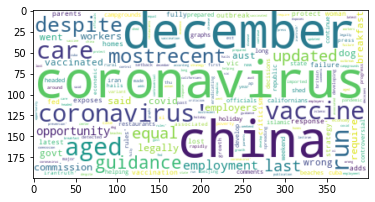

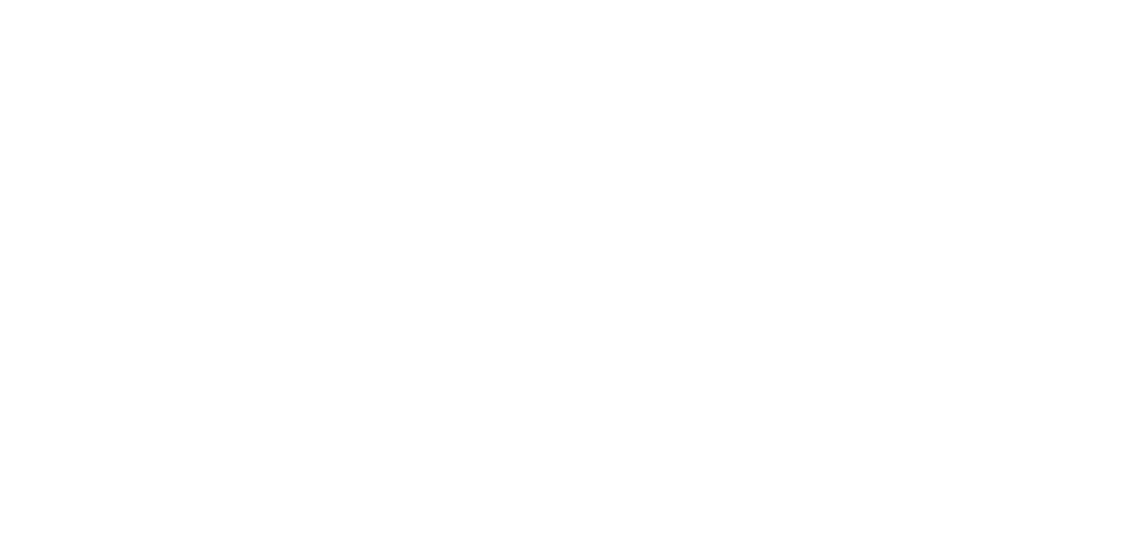

In [7]:
#word cloud for the cleaned text
#!pip install wordcloud
from wordcloud import WordCloud
#function to create word cloud
def create_wordcloud(text):
    eng_stopwords = set(stopwords.words("english"))
    wc = WordCloud(background_color = "white", max_words = 3000, stopwords = eng_stopwords, repeat = True)
    wc.generate(str(text))
    plt.imshow(wc, interpolation='bilinear')
    plt.figure(figsize=(20,10))
    plt.axis("off")
    plt.show()
    
create_wordcloud(data["cleaned_Text"].values)


In [8]:
data['cleaned_Text']

0        mostrecent guidance updated last december equa...
1        dog breakfast aust govt went wrong aged care c...
2        californians headed campgrounds beaches restau...
3        pennsylvania lifted nearly coronavirus restric...
4        not japan cancel games tokyo kept tentative gr...
                               ...                        
75887    africa economy impacted sting africa far spare...
75888    los angeles experiencing surge coronavirus cas...
75889    controversial comments decisions islamic repub...
75890    associated press xi hails china economic growt...
75891    china detected first imported case new coronav...
Name: cleaned_Text, Length: 75892, dtype: object

In [9]:
file_model = data.copy()
file_model = file_model[file_model.cleaned_Text.str.len()>1]

In [10]:
sent = [row for row in file_model.cleaned_Text]
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences[0]

'mostrecent guidance updated last december equal employment opportunity commission said employers legally require workers vaccinated coronavirus'

In [11]:
Word2vec_data = list(map(lambda x: x.split(), sentences))
Word2vec_data

[['mostrecent',
  'guidance',
  'updated',
  'last',
  'december',
  'equal',
  'employment',
  'opportunity',
  'commission',
  'said',
  'employers',
  'legally',
  'require',
  'workers',
  'vaccinated',
  'coronavirus'],
 ['dog',
  'breakfast',
  'aust',
  'govt',
  'went',
  'wrong',
  'aged',
  'care',
  'covid',
  'response',
  'vic',
  'latest',
  'outbreak',
  'exposes',
  'failure',
  'fully',
  'protect',
  'fed',
  'run',
  'aged',
  'care',
  'homes',
  'woman',
  'lost',
  'parents',
  'coronavirus',
  'adds',
  'criticism',
  'vaccination',
  'strategy'],
 ['californians',
  'headed',
  'campgrounds',
  'beaches',
  'restaurants',
  'long',
  'holiday',
  'weekend',
  'state',
  'prepared',
  'shed',
  'coronavirus',
  'rules'],
 ['pennsylvania',
  'lifted',
  'nearly',
  'coronavirus',
  'restrictions',
  'leading',
  'memorial',
  'day',
  'resembling',
  'years',
  'past'],
 ['not',
  'japan',
  'cancel',
  'games',
  'tokyo',
  'kept',
  'tentative',
  'grip',
  'cor

In [12]:
#NEEDS TO BE MODIFIED# TODO
'''
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     workers=multiprocessing.cpu_count()-1)


#%%time
'''
# Defining the model and training it.

w2v_model = Word2Vec(Word2vec_data,
                 vector_size=100,
#                 sample=1e-5, 
#                 alpha=0.03, 
#                 min_alpha=0.0007,
#                 negative=20,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(w2v_model.wv.key_to_index))

start = time()

#w2v_model.build_vocab(sentences, progress_per=50000)

print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))

Vocabulary Length: 15654
Time to build vocab: 0.0 mins


In [13]:
start = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

w2v_model.init_sims(replace=True)

Time to train the model: 1.51 mins


<ipython-input-13-9cdc5012bacd>:7: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [14]:
print(sentences[0])
w2v_model

mostrecent guidance updated last december equal employment opportunity commission said employers legally require workers vaccinated coronavirus


In [15]:
w2v_model.save("word2vec.model")

In [16]:
file_export = file_model.copy()
file_export.head()

,Datetime,Tweet Id,Place,Text,Username,FollowersCount,FriendsCount,Language,Hashtag,Retweet Count,Likes Count,cleaned_Text
0,2021-05-31 23:57:57+00:00,1399515526783774728,East Coast USA,In its most-recent guidance updated last Decem...,WSeparates,5059,5552,en,NaN,0,0,mostrecent guidance updated last december equa...
1,2021-05-31 23:41:40+00:00,1399511428613111808,Australia,‘A dog’s breakfast’: where the Aust Govt went ...,MSMWatchdog2013,20247,21540,en,NaN,1,5,dog breakfast aust govt went wrong aged care c...
2,2021-05-31 23:40:00+00:00,1399511006284378113,San Francisco,"Californians headed to campgrounds, beaches an...",KCBSRadio,49198,4446,en,NaN,3,9,californians headed campgrounds beaches restau...
3,2021-05-31 23:31:00+00:00,1399508741393944581,"Pittsburgh, PA",Pennsylvania has lifted nearly all of its coro...,KDKA,198336,284,en,NaN,1,12,pennsylvania lifted nearly coronavirus restric...
4,2021-05-31 23:28:34+00:00,1399508128954081281,"Sydney, New South Wales",Why can't #Japan just cancel the games? Tokyo ...,abcmatt,6740,558,en,"['Japan', 'olympics2021']",0,2,not japan cancel games tokyo kept tentative gr...


In [17]:
print(sentences[0])

mostrecent guidance updated last december equal employment opportunity commission said employers legally require workers vaccinated coronavirus


In [18]:
file_export['old_cleaned_Text'] = file_export['cleaned_Text']
file_export.old_cleaned_Text = file_export.old_cleaned_Text.str.join('')
file_export.cleaned_Text = file_export.cleaned_Text.apply(lambda x: ''.join(bigram[x]))
#file_export.rate = file_export.rate.astype('int8')

In [19]:
file_export.head()

,Datetime,Tweet Id,Place,Text,Username,FollowersCount,FriendsCount,Language,Hashtag,Retweet Count,Likes Count,cleaned_Text,old_cleaned_Text
0,2021-05-31 23:57:57+00:00,1399515526783774728,East Coast USA,In its most-recent guidance updated last Decem...,WSeparates,5059,5552,en,NaN,0,0,mostrecent guidance updated last december equa...,mostrecent guidance updated last december equa...
1,2021-05-31 23:41:40+00:00,1399511428613111808,Australia,‘A dog’s breakfast’: where the Aust Govt went ...,MSMWatchdog2013,20247,21540,en,NaN,1,5,dog breakfast aust govt went wrong aged care c...,dog breakfast aust govt went wrong aged care c...
2,2021-05-31 23:40:00+00:00,1399511006284378113,San Francisco,"Californians headed to campgrounds, beaches an...",KCBSRadio,49198,4446,en,NaN,3,9,californians headed campgrounds beaches restau...,californians headed campgrounds beaches restau...
3,2021-05-31 23:31:00+00:00,1399508741393944581,"Pittsburgh, PA",Pennsylvania has lifted nearly all of its coro...,KDKA,198336,284,en,NaN,1,12,pennsylvania lifted nearly coronavirus restric...,pennsylvania lifted nearly coronavirus restric...
4,2021-05-31 23:28:34+00:00,1399508128954081281,"Sydney, New South Wales",Why can't #Japan just cancel the games? Tokyo ...,abcmatt,6740,558,en,"['Japan', 'olympics2021']",0,2,not japan cancel games tokyo kept tentative gr...,not japan cancel games tokyo kept tentative gr...


In [20]:
file_export[['cleaned_Text']].to_csv('cleaned_dataset.csv', index=False)

In [21]:
word_vectors = Word2Vec.load("word2vec.model").wv
print(word_vectors)

In [22]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X=word_vectors.vectors.astype('double'))

# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04,...,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04,1.565400e+04
mean,2.485129e-17,-6.055375e-17,5.049426e-17,3.424571e-16,-2.499314e-16,-1.726293e-16,2.228318e-16,-1.705672e-16,3.310669e-17,-1.709236e-18,...,2.550946e-16,5.811401e-17,1.737605e-17,-2.754635e-17,-2.367398e-16,-3.883866e-16,1.024690e-16,2.954637e-16,-2.564066e-16,1.099301e-18
std,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,...,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00
min,-4.117512e+00,-4.365966e+00,-3.820990e+00,-4.333286e+00,-3.527812e+00,-3.952845e+00,-4.945643e+00,-4.468476e+00,-5.536127e+00,-3.825964e+00,...,-4.254156e+00,-4.439767e+00,-4.940253e+00,-3.525389e+00,-4.560255e+00,-5.011794e+00,-6.715685e+00,-4.006798e+00,-5.009735e+00,-4.628357e+00
25%,-6.203441e-01,-5.930473e-01,-6.457722e-01,-6.644620e-01,-6.757110e-01,-6.876127e-01,-6.080720e-01,-6.157549e-01,-6.187227e-01,-6.704460e-01,...,-6.249551e-01,-6.259239e-01,-6.074872e-01,-6.605900e-01,-6.190537e-01,-6.067778e-01,-6.336275e-01,-6.885704e-01,-5.453926e-01,-6.275155e-01
50%,1.553872e-02,1.085339e-01,-7.123671e-03,-8.652171e-02,-4.057014e-02,-1.158815e-01,2.621268e-02,1.005052e-01,4.530327e-02,-6.564669e-02,...,4.105479e-02,1.869901e-02,6.848051e-02,-3.480438e-02,3.117196e-02,7.625889e-02,-1.287829e-02,-7.555536e-02,1.294836e-01,2.237116e-02
75%,6.348485e-01,6.883199e-01,6.514187e-01,5.717698e-01,6.435458e-01,5.969792e-01,6.396458e-01,6.998134e-01,6.487621e-01,6.159452e-01,...,6.672257e-01,6.382815e-01,6.629315e-01,6.142963e-01,6.518082e-01,6.915501e-01,6.292612e-01,6.183925e-01,6.765250e-01,6.234839e-01
max,3.946230e+00,3.053208e+00,4.350876e+00,4.629102e+00,5.058289e+00,4.525366e+00,4.906109e+00,2.853922e+00,3.866403e+00,4.174322e+00,...,4.145865e+00,5.231415e+00,3.667545e+00,6.015654e+00,4.088773e+00,3.601152e+00,4.100338e+00,4.655453e+00,3.046585e+00,4.141861e+00


In [23]:
pca = PCA(n_components=100)
pca_result = pca.fit_transform(X=word_vectors.vectors.astype('double'))
pca_result

array([[ 0.18667459,  0.64514679,  0.0284091 , ...,  0.00202193,
        -0.01507128,  0.01441641],
       [ 0.27763807,  0.57249741,  0.49936999, ...,  0.00128727,
        -0.01396274, -0.01152053],
       [ 0.27055347,  0.47665759, -0.26279197, ..., -0.00548279,
         0.00091251, -0.01641132],
       ...,
       [ 0.3604815 ,  0.1471012 , -0.05953366, ...,  0.00365303,
         0.00916536, -0.00841225],
       [-0.02268063, -0.20295877,  0.1174047 , ..., -0.0174966 ,
         0.0309235 ,  0.00138306],
       [ 0.29529073,  0.14198117, -0.32566925, ..., -0.00445877,
        -0.0048909 ,  0.00445904]])

In [24]:
model = KMeans(n_clusters=24, init='k-means++', max_iter=1000, random_state=True, n_init=50).fit(pca_result)
#model = KMeans(n_clusters=24, init='k-means++', max_iter=1000, random_state=True, n_init=50).fit(data_scaled)
#model = KMeans(n_clusters=11, init='k-means++', max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))
first_cluster_center = model.cluster_centers_[0]
second_cluster_center = model.cluster_centers_[1]
third_cluster_center = model.cluster_centers_[2]
fourth_cluster_center = model.cluster_centers_[3]
fifth_cluster_center = model.cluster_centers_[4]
sixth_cluster_center = model.cluster_centers_[5]
seventh_cluster_center = model.cluster_centers_[6]
eigth_cluster_center = model.cluster_centers_[7]
nineth_cluster_center = model.cluster_centers_[8]
tenth_cluster_center = model.cluster_centers_[9]
eleventh_cluster_center = model.cluster_centers_[10]
twelth_cluster_center = model.cluster_centers_[11]
thirteen_cluster_center = model.cluster_centers_[12]
fourteen_cluster_center = model.cluster_centers_[13]
fifteen_cluster_center = model.cluster_centers_[14]
sixteen_cluster_center = model.cluster_centers_[15]
seventeen_cluster_center = model.cluster_centers_[16]
eighteen_cluster_center = model.cluster_centers_[17]
nineteen_cluster_center = model.cluster_centers_[18]
twenty_cluster_center = model.cluster_centers_[19]
twentyone_cluster_center = model.cluster_centers_[20]
twentytwo_cluster_center = model.cluster_centers_[21]
twentythree_cluster_center = model.cluster_centers_[22]
twentyfour_cluster_center = model.cluster_centers_[23]

In [25]:
first_cluster_index = 1
positive_cluster_center = model.cluster_centers_[first_cluster_index]
negative_cluster_center = model.cluster_centers_[1-first_cluster_index]

In [26]:
model.inertia_

5798.359388173875

In [27]:
#Return 5 centroids
model.cluster_centers_

array([[ 2.64147929e-01,  4.97642157e-01, -6.15568936e-02, ...,
         3.63875823e-04,  2.27853589e-04,  8.39174211e-04],
       [ 8.43511245e-02, -2.36161809e-01, -6.55671439e-02, ...,
        -9.01073839e-05,  9.58653763e-05, -4.08609315e-04],
       [ 2.60293908e-01, -5.53732319e-02, -1.42700226e-01, ...,
         4.49701654e-04, -8.70964401e-04, -9.52826125e-04],
       ...,
       [ 3.32798693e-01,  2.96376869e-01,  2.65468535e-01, ...,
         4.71266643e-04, -2.65577725e-04,  5.73081797e-05],
       [ 9.88791350e-02,  1.30625133e-01,  4.70934258e-01, ...,
        -6.78294126e-05, -3.33970943e-04, -2.54435280e-04],
       [ 4.32753610e-02, -1.31773405e-02,  3.89927177e-02, ...,
        -1.10465414e-03,  5.44178741e-04, -7.39092782e-04]])

In [28]:
model.labels_[:10]# first 10 predictive labels

array([ 0, 21, 19,  0, 11,  0, 17,  0,  0, 17])

In [29]:
'''
#Use this block to find the no of clusters
kmeans_kwargs = {
       "init": "random",
       "n_init": 50,
       "max_iter": 1000,
       "random_state": 42,
}
# A list holds the SSE values for each k
sse=[]
for k in range(1, 51):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X=word_vectors.vectors.astype('double'))
    sse.append(kmeans.inertia_)
'''

'\n#Use this block to find the no of clusters\nkmeans_kwargs = {\n       "init": "random",\n       "n_init": 50,\n       "max_iter": 1000,\n       "random_state": 42,\n}\n# A list holds the SSE values for each k\nsse=[]\nfor k in range(1, 51):\n    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)\n    kmeans.fit(X=word_vectors.vectors.astype(\'double\'))\n    sse.append(kmeans.inertia_)\n'

In [30]:
'''
#Use this block to find the no of clusters
plt.style.use("fivethirtyeight")
plt.plot(range(1, 51), sse)
plt.xticks(range(1, 51))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

plt.show()
'''

'\n#Use this block to find the no of clusters\nplt.style.use("fivethirtyeight")\nplt.plot(range(1, 51), sse)\nplt.xticks(range(1, 51))\nplt.xlabel("Number of Clusters")\nplt.ylabel("SSE")\n\nplt.show()\n'

In [31]:
#Use this block to find the no of clusters using knee locator
#kl = KneeLocator(
#        range(1, 51), sse, curve="convex", direction="decreasing"
 #   )

#kl.elbow


In [32]:
#check what word vectors are most similar in terms of cosine similarity to coordinates of first cluster
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=10, restrict_vocab=None)

[('discovery', 0.3652087152004242),
 ('leak', 0.34261077642440796),
 ('worrying', 0.3387024402618408),
 ('conquering', 0.3296508193016052),
 ('australian', 0.3258473873138428),
 ('joshrogin', 0.3257620632648468),
 ('virology', 0.32317543029785156),
 ('lab', 0.319247305393219),
 ('inhibits', 0.3161063492298126),
 ('research', 0.31226712465286255)]

In [33]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=10, restrict_vocab=None)

[('part', 0.27439096570014954),
 ('towards', 0.24844039976596832),
 ('set', 0.23261037468910217),
 ('year', 0.22230064868927002),
 ('spring', 0.21636423468589783),
 ('series', 0.20528624951839447),
 ('becoming', 0.20220988988876343),
 ('traction', 0.20120356976985931),
 ('season', 0.20118337869644165),
 ('quarter', 0.19906607270240784)]

In [34]:
word_vectors.similar_by_vector(model.cluster_centers_[2], topn=10, restrict_vocab=None)

[('n', 0.3583243787288666),
 ('brazilians', 0.34694617986679077),
 ('moment', 0.3216226398944855),
 ('apologised', 0.3213764727115631),
 ('whodrtedrosjohnshopkinsecdcoutbreaksmsfrkidewhoemrowhoateuantonioguterresafp',
  0.3155587315559387),
 ('column', 0.3137354850769043),
 ('mismanagement', 0.3118586838245392),
 ('r', 0.311292827129364),
 ('aspect', 0.3097311854362488),
 ('donaldtrump', 0.3075815737247467)]

In [35]:
word_vectors.similar_by_vector(model.cluster_centers_[3], topn=40, restrict_vocab=None)

[('care', 0.25238701701164246),
 ('said', 0.240293949842453),
 ('younger', 0.2305363118648529),
 ('conditions', 0.2262163609266281),
 ('throng', 0.224946528673172),
 ('vast', 0.22291377186775208),
 ('enough', 0.2224353700876236),
 ('need', 0.21879906952381134),
 ('working', 0.21813969314098358),
 ('continue', 0.20934940874576569),
 ('reduce', 0.20869146287441254),
 ('limit', 0.2063184380531311),
 ('tokyo', 0.20513053238391876),
 ('protect', 0.20137228071689606),
 ('underlying', 0.20133553445339203),
 ('wear', 0.19876840710639954),
 ('data', 0.19873982667922974),
 ('runaway', 0.19692157208919525),
 ('quickly', 0.19627317786216736),
 ('able', 0.195668563246727),
 ('elderly', 0.19566763937473297),
 ('not', 0.1955019235610962),
 ('groomed', 0.19409604370594025),
 ('participate', 0.19390515983104706),
 ('complicate', 0.19241991639137268),
 ('olympics', 0.19220341742038727),
 ('erase', 0.18952518701553345),
 ('prevent', 0.1883150190114975),
 ('let', 0.18816685676574707),
 ('required', 0.1866

In [36]:
word_vectors.similar_by_vector(model.cluster_centers_[4], topn=20, restrict_vocab=None)

[('outside', 0.3065651059150696),
 ('w', 0.2432345747947693),
 ('p', 0.2411145120859146),
 ('started', 0.23555289208889008),
 ('garments', 0.23358313739299774),
 ('taba', 0.23234505951404572),
 ('correctional', 0.2309112548828125),
 ('escapes', 0.2300957590341568),
 ('buildings', 0.2272486686706543),
 ('v', 0.2263386994600296),
 ('wearing', 0.22465966641902924),
 ('plateau', 0.22361531853675842),
 ('lifted', 0.22231900691986084),
 ('making', 0.22086480259895325),
 ('require', 0.21920403838157654),
 ('african', 0.2152012437582016),
 ('opening', 0.21457332372665405),
 ('west', 0.21353286504745483),
 ('spills', 0.21247056126594543),
 ('allowing', 0.21207594871520996)]

In [37]:
word_vectors.similar_by_vector(model.cluster_centers_[5], topn=20, restrict_vocab=None)

[('paycheck', 0.3194257616996765),
 ('preregistration', 0.3068123459815979),
 ('registration', 0.2887737452983856),
 ('available', 0.28309985995292664),
 ('reallife', 0.2787737548351288),
 ('offers', 0.272776335477829),
 ('headlines', 0.26105281710624695),
 ('mass', 0.25539276003837585),
 ('vaccination', 0.25419121980667114),
 ('healthcare', 0.25357481837272644),
 ('today', 0.2515942454338074),
 ('immunization', 0.24586643278598785),
 ('efficient', 0.24114781618118286),
 ('latest', 0.23862303793430328),
 ('immunisation', 0.23765063285827637),
 ('appointments', 0.23360924422740936),
 ('montgomerycomd', 0.23128199577331543),
 ('unsettling', 0.22752024233341217),
 ('inoculation', 0.22446390986442566),
 ('relaunches', 0.22402290999889374)]

In [38]:
word_vectors.similar_by_vector(model.cluster_centers_[6], topn=20, restrict_vocab=None)

[('june', 0.44350436329841614),
 ('february', 0.39830729365348816),
 ('march', 0.3579159379005432),
 ('accordng', 0.35253772139549255),
 ('deadline', 0.33275458216667175),
 ('september', 0.32091400027275085),
 ('april', 0.31335145235061646),
 ('extended', 0.30920493602752686),
 ('august', 0.3070202171802521),
 ('closure', 0.30398067831993103),
 ('end', 0.3035358786582947),
 ('scheduled', 0.30284684896469116),
 ('expiration', 0.2934899926185608),
 ('euwide', 0.2912018299102783),
 ('july', 0.29016920924186707),
 ('postponed', 0.2870117425918579),
 ('franc', 0.2865009009838104),
 ('hold', 0.2837104797363281),
 ('extend', 0.2829726040363312),
 ('intermingling', 0.2790012061595917)]

In [39]:
word_vectors.similar_by_vector(model.cluster_centers_[7], topn=20, restrict_vocab=None)

[('feedback', 0.3316626250743866),
 ('scnews', 0.28777822852134705),
 ('weekly', 0.2715004086494446),
 ('staff', 0.263149231672287),
 ('positive', 0.25545603036880493),
 ('data', 0.254190057516098),
 ('students', 0.23769669234752655),
 ('show', 0.23643359541893005),
 ('tcell', 0.233595609664917),
 ('validate', 0.23060864210128784),
 ('campus', 0.22782056033611298),
 ('system', 0.22387878596782684),
 ('onsite', 0.22241045534610748),
 ('pcr', 0.22159796953201294),
 ('proof', 0.2204027771949768),
 ('official', 0.2202863246202469),
 ('ministry', 0.21941599249839783),
 ('centres', 0.2185232788324356),
 ('marcio', 0.21789045631885529),
 ('showdown', 0.21461884677410126)]

In [40]:
word_vectors.similar_by_vector(model.cluster_centers_[8], topn=20, restrict_vocab=None)

[('sigh', 0.3965100944042206),
 ('followers', 0.39344948530197144),
 ('pandemicstricken', 0.37727662920951843),
 ('block', 0.3741118311882019),
 ('germans', 0.3702669143676758),
 ('dickinson', 0.3648056983947754),
 ('f', 0.36427736282348633),
 ('shelf', 0.36064645648002625),
 ('g', 0.35755491256713867),
 ('highrisk', 0.3572118580341339),
 ('bello', 0.3552696406841278),
 ('w', 0.3518418073654175),
 ('doctors', 0.34997743368148804),
 ('red', 0.34805020689964294),
 ('v', 0.3459937572479248),
 ('agree', 0.3440038859844208),
 ('ared', 0.3434986472129822),
 ('doubtful', 0.34290003776550293),
 ('journalists', 0.3419959247112274),
 ('marr', 0.34034571051597595)]

In [41]:
word_vectors.similar_by_vector(model.cluster_centers_[9], topn=20, restrict_vocab=None)

[('fueling', 0.30633804202079773),
 ('maturity', 0.2644868493080139),
 ('house', 0.24972623586654663),
 ('york', 0.21977540850639343),
 ('wartime', 0.21867315471172333),
 ('rains', 0.21026283502578735),
 ('million', 0.20960316061973572),
 ('lauren', 0.2054193764925003),
 ('night', 0.20321524143218994),
 ('march', 0.20013108849525452),
 ('sight', 0.1992984563112259),
 ('late', 0.1985192894935608),
 ('white', 0.19829945266246796),
 ('season', 0.19756370782852173),
 ('yorker', 0.19736987352371216),
 ('americans', 0.19551867246627808),
 ('sniff', 0.19508114457130432),
 ('date', 0.1928379386663437),
 ('straight', 0.1907903254032135),
 ('miraculously', 0.18970294296741486)]

In [42]:
word_vectors.similar_by_vector(model.cluster_centers_[10], topn=20, restrict_vocab=None)

[('travelrestrictions', 0.26646700501441956),
 ('rerating', 0.2642587423324585),
 ('restrictions', 0.25769633054733276),
 ('lockdown', 0.25703737139701843),
 ('maturity', 0.25410035252571106),
 ('crisis', 0.23853661119937897),
 ('lockdowns', 0.23580877482891083),
 ('measures', 0.23165741562843323),
 ('higherthanusual', 0.22836503386497498),
 ('infections', 0.22763869166374207),
 ('facing', 0.2181975245475769),
 ('unleash', 0.21494042873382568),
 ('economy', 0.2031485140323639),
 ('operations', 0.19656039774417877),
 ('debt', 0.19490361213684082),
 ('relief', 0.19342046976089478),
 ('curfew', 0.1886579990386963),
 ('emergency', 0.18822413682937622),
 ('quarter', 0.1806703358888626),
 ('tariffs', 0.18038880825042725)]

In [43]:
word_vectors.similar_by_vector(model.cluster_centers_[11], topn=20, restrict_vocab=None)

[('middleincome', 0.3729795515537262),
 ('registration', 0.34777170419692993),
 ('f', 0.33725208044052124),
 ('paycheck', 0.3361268937587738),
 ('doctors', 0.33084866404533386),
 ('vaccination', 0.3183441162109375),
 ('multiple', 0.3076981008052826),
 ('medical', 0.3065411448478699),
 ('offers', 0.30555808544158936),
 ('relaunches', 0.30430540442466736),
 ('produces', 0.3024120628833771),
 ('block', 0.29763755202293396),
 ('tracking', 0.2972598075866699),
 ('highrisk', 0.2929684817790985),
 ('whosponsored', 0.29138121008872986),
 ('associated', 0.29020798206329346),
 ('list', 0.2901861369609833),
 ('nervous', 0.2890740931034088),
 ('filipino', 0.2874557077884674),
 ('reallife', 0.2873736619949341)]

In [44]:
word_vectors.similar_by_vector(model.cluster_centers_[12], topn=20, restrict_vocab=None)

[('crisis', 0.3147136867046356),
 ('economic', 0.2774876356124878),
 ('economy', 0.26466986536979675),
 ('vaccination', 0.2569442093372345),
 ('ambitious', 0.2565833032131195),
 ('slowdown', 0.2530251741409302),
 ('strong', 0.24295133352279663),
 ('recovery', 0.2426726371049881),
 ('costcutting', 0.23838473856449127),
 ('optimism', 0.23400326073169708),
 ('thus', 0.22935141623020172),
 ('curtailing', 0.22291897237300873),
 ('continued', 0.22151495516300201),
 ('revive', 0.22142532467842102),
 ('bondbuying', 0.22020408511161804),
 ('rerating', 0.21955442428588867),
 ('swaths', 0.21668784320354462),
 ('massive', 0.21528360247612),
 ('dyadic', 0.21420839428901672),
 ('learn', 0.21364440023899078)]

In [45]:
word_vectors.similar_by_vector(model.cluster_centers_[13], topn=20, restrict_vocab=None)

[('v', 0.380212664604187),
 ('p', 0.3250214755535126),
 ('trust', 0.3235277831554413),
 ('want', 0.3188409209251404),
 ('germans', 0.3110731840133667),
 ('giving', 0.3086715340614319),
 ('send', 0.29634255170822144),
 ('authorise', 0.2941884696483612),
 ('q', 0.2917434871196747),
 ('toby', 0.2843911349773407),
 ('sir', 0.28311097621917725),
 ('asking', 0.2808382511138916),
 ('chrismasseyfois', 0.27949631214141846),
 ('negotiated', 0.27849745750427246),
 ('sleeve', 0.27846917510032654),
 ('agree', 0.27751272916793823),
 ('itsjohnmartin', 0.2771745026111603),
 ('wealthy', 0.27591702342033386),
 ('future', 0.27394425868988037),
 ('metres', 0.2731160521507263)]

In [46]:
word_vectors.similar_by_vector(model.cluster_centers_[14], topn=20, restrict_vocab=None)

[('research', 0.2765248119831085),
 ('mutations', 0.24522988498210907),
 ('cases', 0.2213255614042282),
 ('infections', 0.21525226533412933),
 ('fled', 0.20285864174365997),
 ('strains', 0.1964726448059082),
 ('outbreaks', 0.19369448721408844),
 ('outbreak', 0.18955104053020477),
 ('daycares', 0.18830659985542297),
 ('control', 0.18134284019470215),
 ('variants', 0.17739056050777435),
 ('concern', 0.17364297807216644),
 ('organization', 0.17024214565753937),
 ('spreading', 0.16854676604270935),
 ('transmission', 0.16832873225212097),
 ('emergence', 0.16768500208854675),
 ('immunology', 0.16359759867191315),
 ('zealand', 0.16297785937786102),
 ('ipa', 0.15985116362571716),
 ('taiwan', 0.15369531512260437)]

In [47]:
word_vectors.similar_by_vector(model.cluster_centers_[15], topn=10, restrict_vocab=None)

[('mounted', 0.31699973344802856),
 ('postcodes', 0.31577789783477783),
 ('coordination', 0.30783548951148987),
 ('l', 0.29579833149909973),
 ('four', 0.2808641791343689),
 ('punjab', 0.28061139583587646),
 ('n', 0.27920201420783997),
 ('complicate', 0.2787964940071106),
 ('despotic', 0.2779337763786316),
 ('complicity', 0.27533799409866333)]

In [48]:
word_vectors.similar_by_vector(model.cluster_centers_[16], topn=20, restrict_vocab=None)

[('expect', 0.3300221562385559),
 ('get', 0.2676127851009369),
 ('enmnewshealth', 0.25845879316329956),
 ('read', 0.23510947823524475),
 ('full', 0.22925348579883575),
 ('became', 0.2289564609527588),
 ('banegaswasthindia', 0.22809718549251556),
 ('event', 0.22505953907966614),
 ('latest', 0.22501417994499207),
 ('heregtgtgt', 0.22475625574588776),
 ('reasonably', 0.22379139065742493),
 ('discarded', 0.22270257771015167),
 ('fundfanatic', 0.22051183879375458),
 ('season', 0.21593329310417175),
 ('available', 0.21455122530460358),
 ('cdndigital', 0.21356959640979767),
 ('return', 0.2131444215774536),
 ('round', 0.21252232789993286),
 ('scheme', 0.21119923889636993),
 ('tranche', 0.20993338525295258)]

In [49]:
word_vectors.similar_by_vector(model.cluster_centers_[17], topn=20, restrict_vocab=None)

[('e', 0.3509678244590759),
 ('discovery', 0.3297246992588043),
 ('startling', 0.32871466875076294),
 ('master', 0.32838454842567444),
 ('crisis', 0.32216984033584595),
 ('senseless', 0.31357431411743164),
 ('australian', 0.3083704113960266),
 ('atrocities', 0.3075837194919586),
 ('cw', 0.30476534366607666),
 ('cashing', 0.3046885132789612),
 ('unleash', 0.3033917546272278),
 ('screws', 0.3022594153881073),
 ('mixing', 0.30051884055137634),
 ('catastrophe', 0.3000761866569519),
 ('n', 0.29833748936653137),
 ('cologne', 0.2940998077392578),
 ('bjp', 0.2939174473285675),
 ('communist', 0.28873586654663086),
 ('financiers', 0.2865259349346161),
 ('tariffs', 0.28618067502975464)]

In [50]:
word_vectors.similar_by_vector(model.cluster_centers_[18], topn=20, restrict_vocab=None)

[('expanded', 0.35709473490715027),
 ('expected', 0.33695799112319946),
 ('prepares', 0.3343247175216675),
 ('turkey', 0.31607338786125183),
 ('delayed', 0.3152145445346832),
 ('feb', 0.3145638406276703),
 ('bank', 0.31399261951446533),
 ('planning', 0.31329911947250366),
 ('stage', 0.3120079040527344),
 ('meeting', 0.3097970187664032),
 ('officially', 0.30906420946121216),
 ('planned', 0.3080097734928131),
 ('undertaking', 0.30521219968795776),
 ('greece', 0.30442288517951965),
 ('airbus', 0.30374252796173096),
 ('rollout', 0.3019184470176697),
 ('suspension', 0.2981322705745697),
 ('delay', 0.29675039649009705),
 ('postponed', 0.29411444067955017),
 ('domestic', 0.2930866777896881)]

In [51]:
word_vectors.similar_by_vector(model.cluster_centers_[19], topn=20, restrict_vocab=None)

[('source', 0.4159092307090759),
 ('brazos', 0.39376938343048096),
 ('accidents', 0.3917466104030609),
 ('virology', 0.3869800269603729),
 ('harmless', 0.37486472725868225),
 ('sequencing', 0.37403780221939087),
 ('bats', 0.37111765146255493),
 ('invades', 0.3693171739578247),
 ('proliferation', 0.36809638142585754),
 ('nature', 0.3655495047569275),
 ('wild', 0.36329716444015503),
 ('lab', 0.36326518654823303),
 ('researchers', 0.36156484484672546),
 ('theory', 0.3609563112258911),
 ('imperial', 0.3598945140838623),
 ('bat', 0.3584524989128113),
 ('ccp', 0.3565538823604584),
 ('responsible', 0.35433363914489746),
 ('leak', 0.35412123799324036),
 ('determined', 0.35392406582832336)]

In [52]:
word_vectors.similar_by_vector(model.cluster_centers_[20], topn=20, restrict_vocab=None)

[('guardian', 0.2236570119857788),
 ('misunderstanding', 0.21987135708332062),
 ('spreader', 0.2178722769021988),
 ('torybritain', 0.21504102647304535),
 ('era', 0.20865367352962494),
 ('implications', 0.19960874319076538),
 ('real', 0.19896897673606873),
 ('fuel', 0.19865667819976807),
 ('ethen', 0.19798889756202698),
 ('falsely', 0.1965859979391098),
 ('coronil', 0.19638220965862274),
 ('crisis', 0.1952964812517166),
 ('link', 0.19489724934101105),
 ('con', 0.1936812549829483),
 ('cure', 0.19019703567028046),
 ('post', 0.18999606370925903),
 ('inequality', 0.18888483941555023),
 ('master', 0.18779385089874268),
 ('hartmann', 0.187397763133049),
 ('doublemutant', 0.18590493500232697)]

In [53]:
word_vectors.similar_by_vector(model.cluster_centers_[21], topn=10, restrict_vocab=None)

[('us', 0.34475019574165344),
 ('franciscobased', 0.295809805393219),
 ('bush', 0.2855362296104431),
 ('york', 0.2572769820690155),
 ('jan', 0.24953880906105042),
 ('mexico', 0.24694854021072388),
 ('forecasting', 0.24666184186935425),
 ('along', 0.2344226837158203),
 ('complicity', 0.2318183034658432),
 ('january', 0.23132024705410004)]

In [54]:
word_vectors.similar_by_vector(model.cluster_centers_[22], topn=40, restrict_vocab=None)

[('nine', 0.3717304468154907),
 ('midmarch', 0.3468353748321533),
 ('ohio', 0.34152936935424805),
 ('governor', 0.3394772410392761),
 ('pennsylvania', 0.3380829691886902),
 ('illinois', 0.3373410701751709),
 ('wks', 0.33080992102622986),
 ('june', 0.3305071294307709),
 ('four', 0.32995423674583435),
 ('risen', 0.3265042006969452),
 ('april', 0.3178246021270752),
 ('coronavirusrelated', 0.31751173734664917),
 ('accordng', 0.31575191020965576),
 ('cornwall', 0.31419637799263),
 ('secondworst', 0.31411999464035034),
 ('september', 0.3128259479999542),
 ('tipping', 0.3122760057449341),
 ('franciscobased', 0.3082539141178131),
 ('oregon', 0.3081420958042145),
 ('exempted', 0.3079327344894409),
 ('span', 0.30656832456588745),
 ('kentucky', 0.30597636103630066),
 ('ky', 0.30589917302131653),
 ('wvgovernor', 0.30582311749458313),
 ('landmark', 0.30312374234199524),
 ('threshold', 0.3025679290294647),
 ('mnangagwa', 0.3022531569004059),
 ('twelve', 0.30206480622291565),
 ('partially', 0.3018029

In [55]:
word_vectors.similar_by_vector(model.cluster_centers_[23], topn=20, restrict_vocab=None)

[('hiccup', 0.35455697774887085),
 ('underestimate', 0.3083314001560211),
 ('reinforce', 0.2984120547771454),
 ('stress', 0.28480055928230286),
 ('stealing', 0.2708015739917755),
 ('applicable', 0.26679283380508423),
 ('frightening', 0.2642025351524353),
 ('keep', 0.263274610042572),
 ('dictates', 0.26215076446533203),
 ('utterly', 0.2609923183917999),
 ('coverings', 0.25920233130455017),
 ('signaled', 0.2589138448238373),
 ('greed', 0.25868871808052063),
 ('distancing', 0.25854164361953735),
 ('scandalous', 0.25792616605758667),
 ('riding', 0.25730884075164795),
 ('slap', 0.2571965157985687),
 ('whatever', 0.2566066384315491),
 ('borishasfailedthenation', 0.2556459903717041),
 ('aus', 0.2536451816558838)]

In [56]:
words = pd.DataFrame(word_vectors.key_to_index.keys())
#words = pd.DataFrame(pca_result)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])
words['cluster'].value_counts()
s = pd.DataFrame(index = range(0,len(words)),columns= ['cluster_value'])
for x in range(0,len(words)):
    if(words['cluster'][x] == 0):
        s['cluster_value'][x] = 0.5
        
    elif(words['cluster'][x] == 10):
        s['cluster_value'][x] = 0.5
        
    elif(words['cluster'][x] == 11):
        s['cluster_value'][x] = 0.5
        
    elif(words['cluster'][x] == 12):
        s['cluster_value'][x] = 0.5
        
    elif(words['cluster'][x] == 16):
        s['cluster_value'][x] = 0.5
        
    elif(words['cluster'][x] == 19):
        s['cluster_value'][x] = 0.5
        
    elif(words['cluster'][x] == 23):
        s['cluster_value'][x] = 0.5
        
    elif(words['cluster'][x] == 1):
        s['cluster_value'][x] = -0.5
        
    elif(words['cluster'][x] == 3):
        s['cluster_value'][x] = -0.5
        
    elif(words['cluster'][x] == 4):
        s['cluster_value'][x] = -0.5
        
    elif(words['cluster'][x] == 5):
        s['cluster_value'][x] = -0.5
        
    elif(words['cluster'][x] == 6):
        s['cluster_value'][x] = -0.5
        
    elif(words['cluster'][x] == 13):
        s['cluster_value'][x] = -0.5
        
    elif(words['cluster'][x] == 15):
        s['cluster_value'][x] = -0.5
        
    elif(words['cluster'][x] == 17):
        s['cluster_value'][x] = -0.5
        
    elif(words['cluster'][x] == 20):
        s['cluster_value'][x] = -0.5
        
    elif(words['cluster'][x] == 5):
        s['cluster_value'][x] = -0.8
        
    elif(words['cluster'][x] == 6):
        s['cluster_value'][x] = -0.8
        
    elif(words['cluster'][x] == 8):
        s['cluster_value'][x] = -0.8
        
    elif(words['cluster'][x] == 18):
        s['cluster_value'][x] = -0.8
        
    elif(words['cluster'][x] == 21):
        s['cluster_value'][x] = -0.8
        
    elif (words['cluster'][x] == 2):
        s['cluster_value'][x] = 0.8
        
    elif(words['cluster'][x] == 7):
        s['cluster_value'][x] = 0.8
        
    elif(words['cluster'][x] == 14):
        s['cluster_value'][x] = 0.8
        
    elif(words['cluster'][x] == 23):
        s['cluster_value'][x] = 0.8
        
    elif(words['cluster'][x] == 9):
        s['cluster_value'][x] = 0.8
        
    elif(words['cluster'][x] == 22):
        s['cluster_value'][x] = 0.8

words['cluster_value'] = s['cluster_value']
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [57]:
words.cluster_value.value_counts()

-0.5    8086
 0.5    4461
 0.8    2597
-0.8     510
Name: cluster_value, dtype: int64

In [58]:
words.cluster.value_counts()

13    3794
20    2561
23    1968
19    1398
16    1040
9      994
2      935
18     451
22     407
3      397
6      332
5      312
4      280
7      260
15     216
1      187
8       57
12      30
0       10
10       8
11       7
17       7
21       2
14       1
Name: cluster, dtype: int64

In [59]:
'''
joy_cluster_index = 0.65
surprise_cluster_index = 0.35
anger_cluster_center = -0.65
fear_cluster_center = -0.35
sadness_cluster_center = -0.0
joy_cluster_index = model.cluster_centers_[joy_cluster_index]
surprise_cluster_index = model.cluster_centers_[1-joy_cluster_index]
anger_cluster_center  = model.cluster_centers_[anger_cluster_center]
fear_cluster_center  = model.cluster_centers_[fear_cluster_center]
sadness_cluster_center  = model.cluster_centers_[sadness_cluster_center]
'''

'\njoy_cluster_index = 0.65\nsurprise_cluster_index = 0.35\nanger_cluster_center = -0.65\nfear_cluster_center = -0.35\nsadness_cluster_center = -0.0\njoy_cluster_index = model.cluster_centers_[joy_cluster_index]\nsurprise_cluster_index = model.cluster_centers_[1-joy_cluster_index]\nanger_cluster_center  = model.cluster_centers_[anger_cluster_center]\nfear_cluster_center  = model.cluster_centers_[fear_cluster_center]\nsadness_cluster_center  = model.cluster_centers_[sadness_cluster_center]\n'

In [60]:
#def calculate_sentiment(Clean_text):
#    return TextBlob(Clean_text).sentiment

In [61]:
#!pip install vaderSentiment
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#analyser = SentimentIntensityAnalyzer()

In [62]:
#def calculate_sentiment_analyser(Clean_text):    
#    return analyser.polarity_scores(Clean_text)

In [63]:
'''
from textblob import TextBlob

file_export["sentiment"]=data.cleaned_Text.apply(calculate_sentiment)
file_export["sentiment_analyser"]=data.cleaned_Text.apply(calculate_sentiment_analyser)


s = pd.DataFrame(index = range(0,len(file_export)),columns= ['compound_score','compound_score_sentiment'])

for i in range(0,len(file_export)): 
  s['compound_score'][i] = file_export['sentiment_analyser'][i]['compound']

  if (file_export['sentiment_analyser'][i]['compound'] >= -0.08) & (file_export['sentiment_analyser'][i]['compound'] < -0.1):
    s['compound_score_sentiment'][i] = "0" #'anger'    
  if (file_export['sentiment_analyser'][i]['compound'] >= -0.05)& (file_export['sentiment_analyser'][i]['compound'] < -0.02):
    s['compound_score_sentiment'][i] = '1'#'fear'
  if ((file_export['sentiment_analyser'][i]['compound'] >= -0.02) & (file_export['sentiment_analyser'][i]['compound'] < -0.00)):
    s['compound_score_sentiment'][i] = '2'#'sadness'
  if (file_export['sentiment_analyser'][i]['compound'] >= 0.1) & (file_export['sentiment_analyser'][i]['compound'] < 0.10):
    s['compound_score_sentiment'][i] = '3'#'joy' 
  if (file_export['sentiment_analyser'][i]['compound'] >= 0.06) & (file_export['sentiment_analyser'][i]['compound'] <= 0.00):
    s['compound_score_sentiment'][i] = '5'#'surprise' 

file_export['compound_score'] = s['compound_score']
file_export['compound_score_sentiment'] = s['compound_score_sentiment']
file_export.head
'''

'\nfrom textblob import TextBlob\n\nfile_export["sentiment"]=data.cleaned_Text.apply(calculate_sentiment)\nfile_export["sentiment_analyser"]=data.cleaned_Text.apply(calculate_sentiment_analyser)\n\n\ns = pd.DataFrame(index = range(0,len(file_export)),columns= [\'compound_score\',\'compound_score_sentiment\'])\n\nfor i in range(0,len(file_export)): \n  s[\'compound_score\'][i] = file_export[\'sentiment_analyser\'][i][\'compound\']\n\n  if (file_export[\'sentiment_analyser\'][i][\'compound\'] >= -0.08) & (file_export[\'sentiment_analyser\'][i][\'compound\'] < -0.1):\n    s[\'compound_score_sentiment\'][i] = "0" #\'anger\'    \n  if (file_export[\'sentiment_analyser\'][i][\'compound\'] >= -0.05)& (file_export[\'sentiment_analyser\'][i][\'compound\'] < -0.02):\n    s[\'compound_score_sentiment\'][i] = \'1\'#\'fear\'\n  if ((file_export[\'sentiment_analyser\'][i][\'compound\'] >= -0.02) & (file_export[\'sentiment_analyser\'][i][\'compound\'] < -0.00)):\n    s[\'compound_score_sentiment\'][i

In [64]:
words.head(1000)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,coronavirus,"[-0.03628151, -0.003513508, 0.15666524, 0.0399...",9,0.8,0.983974,0.787179
1,vaccine,"[-0.16330044, -0.030478114, 0.052976515, 0.071...",5,-0.5,0.999611,-0.499805
2,pandemic,"[0.19998305, -0.018993339, -0.04813633, -0.016...",2,0.8,0.992111,0.793689
3,new,"[-0.0050212326, 0.08227492, -0.05667195, 0.060...",20,-0.5,0.969084,-0.484542
4,not,"[-0.13877939, 0.07284705, 0.13884561, -0.02420...",13,-0.5,1.017181,-0.508591
...,...,...,...,...,...,...
995,facility,"[-0.108795665, 0.13263746, 0.12499866, 0.07957...",5,-0.5,0.983266,-0.491633
996,borisjohnson,"[-0.018711582, 0.057226703, -0.037020467, -0.1...",23,0.5,0.986213,0.493106
997,remember,"[-0.0467052, -0.031381384, -0.08501318, 0.0448...",20,-0.5,0.990356,-0.495178
998,nytimes,"[0.10508473, 0.065541565, -0.07622293, 0.03589...",20,-0.5,0.985382,-0.492691


In [65]:
words.sentiment_coeff

0        0.787179
1       -0.499805
2        0.793689
3       -0.484542
4       -0.508591
           ...   
15649    0.799162
15650    0.482805
15651   -0.489349
15652   -0.493208
15653   -0.486253
Name: sentiment_coeff, Length: 15654, dtype: object

In [66]:
words[['words', 'sentiment_coeff']].to_csv('sentiment_dictionary.csv', index=False)

In [67]:
final_file = pd.read_csv('cleaned_dataset.csv')

In [68]:
sentiment_map = pd.read_csv('sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

In [69]:
file_weighting = final_file.copy()

In [70]:
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(file_weighting.cleaned_Text)
features = pd.Series(tfidf.get_feature_names())
transformed = tfidf.transform(file_weighting.cleaned_Text)

C:\Users\Naveena\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [71]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    inspired  by function from this wonderful article: 
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.cleaned_Text.split()))

In [72]:
%%time
replaced_tfidf_scores = file_weighting.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)#this step takes around 3-4 minutes minutes

Wall time: 22.8 s


In [73]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [74]:
replaced_closeness_scores = file_weighting.cleaned_Text.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [75]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, file_weighting.cleaned_Text]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
sentiment_rate = (replacement_df['sentiment_rate']).astype(int)

replacement_df['sentiment_rate'] = sentiment_rate
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')
#replacement_df['sentiment'] = [1 if i==1 else 0 for i in replacement_df.sentiment]

In [120]:
s = pd.DataFrame(index = range(0,len(replacement_df)),columns= ['emotion'])

for i in range(0,len(replacement_df)):
    if (replacement_df['sentiment_rate'][i]) >= 24:
        s['emotion'][i] = 'joy'
    elif (replacement_df['sentiment_rate'][i]) >= 1 & (replacement_df['sentiment_rate'][i]) <= 20:
        s['emotion'][i] = 'trust'
    elif (replacement_df['sentiment_rate'][i]) >= -1 & (replacement_df['sentiment_rate'][i]) < -10: 
        s['emotion'][i] = 'fear'
    elif (replacement_df['sentiment_rate'][i]) >= -20:  
        s['emotion'][i] = 'anger'
    
        
replacement_df['emotion'] = s['emotion']

In [121]:
replacement_df

,sentiment_coeff,tfidf_scores,sentence,sentiment_rate,prediction,emotion
0,"[-0.4862533295342662, 0.4960825137470297, 0.79...","[10.445320263288565, 5.941813731076974, 5.7709...",mostrecent guidance updated last december equa...,-13,0,fear
1,"[-0.4904948632553947, -0.4919537632714178, 0.4...","[8.266787818964499, 9.934494639522574, 10.4453...",dog breakfast aust govt went wrong aged care c...,-10,0,anger
2,"[0.7894737650347093, 0.795616434428291, 0.4918...","[9.241347458962629, 8.408438336027526, 10.4453...",californians headed campgrounds beaches restau...,50,1,joy
3,"[0.8282658549722117, -0.5058750394983502, 0.78...","[7.5096919138042795, 6.5332972578604185, 5.229...",pennsylvania lifted nearly coronavirus restric...,14,1,trust
4,"[-0.5085905591683723, -0.8147091783390416, -0....","[3.1889054111308273, 5.572670712166212, 7.1681...",not japan cancel games tokyo kept tentative gr...,1,1,trust
...,...,...,...,...,...,...
75887,"[0.4992582352355756, -0.5082746183661704, 0.49...","[10.389587121153752, 9.526885248040827, 7.4330...",africa economy impacted sting africa far spare...,6,1,trust
75888,"[0.781808330864656, 0.7814936704707999, 0.7735...","[7.066595737478468, 7.1372133046924215, 6.9900...",los angeles experiencing surge coronavirus cas...,24,1,joy
75889,"[0.7875362790786854, 0.7947205326705644, -0.49...","[7.74844336278448, 7.74844336278448, 7.5457318...",controversial comments decisions islamic repub...,10,1,trust
75890,"[0.5095292611796859, -0.4856094511706885, 0.81...","[6.503738455618874, 6.5332972578604185, 8.3250...",associated press xi hails china economic growt...,0,0,trust


In [122]:
print(replacement_df.sentiment_coeff[0])

[-0.4862533295342662, 0.4960825137470297, 0.7922416038579506, -0.4934521253636977, -0.4959368757268982, -0.4882905877163419, 0.4919922759510792, -0.497028713841441, 0.7977785046734135, -0.5118359035549926, -0.5055784642248988, -0.4859527673848821, -0.5095805591175007, 0.804705665455486, -0.4936898028013369, 0.7871788615555753]


In [123]:
print(replacement_df.sentence[0])

mostrecent guidance updated last december equal employment opportunity commission said employers legally require workers vaccinated coronavirus


In [124]:
final_file_export = replacement_df.copy()
final_file_export.head()

,sentiment_coeff,tfidf_scores,sentence,sentiment_rate,prediction,emotion
0,"[-0.4862533295342662, 0.4960825137470297, 0.79...","[10.445320263288565, 5.941813731076974, 5.7709...",mostrecent guidance updated last december equa...,-13,0,fear
1,"[-0.4904948632553947, -0.4919537632714178, 0.4...","[8.266787818964499, 9.934494639522574, 10.4453...",dog breakfast aust govt went wrong aged care c...,-10,0,anger
2,"[0.7894737650347093, 0.795616434428291, 0.4918...","[9.241347458962629, 8.408438336027526, 10.4453...",californians headed campgrounds beaches restau...,50,1,joy
3,"[0.8282658549722117, -0.5058750394983502, 0.78...","[7.5096919138042795, 6.5332972578604185, 5.229...",pennsylvania lifted nearly coronavirus restric...,14,1,trust
4,"[-0.5085905591683723, -0.8147091783390416, -0....","[3.1889054111308273, 5.572670712166212, 7.1681...",not japan cancel games tokyo kept tentative gr...,1,1,trust


In [125]:
final_file_export['sentiment_rate'].value_counts()

 0      2672
-2      1685
 4      1548
 6      1493
 17     1336
        ... 
 119       1
 141       1
-115       1
 120       1
-129       1
Name: sentiment_rate, Length: 290, dtype: int64

In [126]:
final_file_export['emotion'].value_counts()

trust    28114
fear     22687
joy      12867
anger    12224
Name: emotion, dtype: int64

C:\Users\Naveena\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='emotion', ylabel='count'>

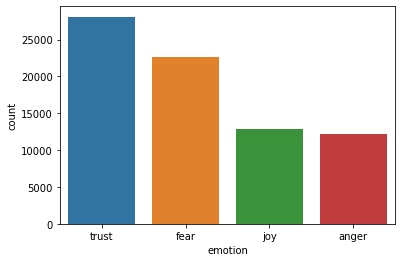

In [128]:
sns.countplot(final_file_export['emotion'],order = final_file_export['emotion'].value_counts(normalize=False).index)

In [129]:
final_file_export['prediction'].value_counts()

1    38309
0    37583
Name: prediction, dtype: int64

In [130]:
deselectlist =[ 'sentiment_coeff', 'tfidf_scores']
selectlist =[x for x in final_file_export.columns if x not in deselectlist]
datatowrite = final_file_export[selectlist]
datatowrite.to_csv('final_emotions_dataset_Unsupervised.csv', index=False)

In [138]:
'''
predicted_classes = final_file_export.prediction

test_scores = accuracy_score(y_test,predicted_classes), precision_score(y_test, predicted_classes), recall_score(y_test, predicted_classes), f1_score(y_test, predicted_classes)

print('\n \n Scores')
scores = pd.DataFrame(data=[test_scores])
scores.columns = ['accuracy', 'precision', 'recall', 'f1']
scores = scores.T
scores.columns = ['scores']
display(scores)
'''

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.